<h1>Deep Learning for MNIST Handwritten Digit Recognition<h1>
<h4>The MNIST dataset contains 70,000 grayscale images of handwritten digits (60,000 for training and 10,000 for testing). Each image is 28x28 pixels with values from 0 to 255. The label assigned to each image is the digit it represents (0 to 9). Widely used in computer vision, MNIST serves as a starting point for deep learning due to its manageable size and essential preprocessing and model design challenges.<h4>

In [10]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import torch.nn.functional as F


<h4>Import essential libraries and load the dataset using PyTorch's torchvision, which provides the built-in MNIST dataset.<h4>

In [11]:
# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data',
										train=True,
										transform=torchvision.transforms.ToTensor(),
										download=True)
test_dataset = torchvision.datasets.MNIST(root='./data',
										train=False,
										transform=torchvision.transforms.ToTensor(),
										download=True)


<h4>The `Classifier` class, a subclass of PyTorch's `nn.Module`, outlines the CNN's architecture. This class includes the network's forward pass method.<h4>

In [12]:
class Classifier(nn.Module):
	def __init__(self):
		super().__init__()
		self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
		self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
		self.pool = nn.MaxPool2d(2, 2)
		self.dropout1 = nn.Dropout2d(0.25)
		self.dropout2 = nn.Dropout2d(0.5)
		self.fc1 = nn.Linear(64 * 7 * 7, 128)
		self.fc2 = nn.Linear(128, 10)

	def forward(self, x):
		x = self.pool(F.relu(self.conv1(x)))
		x = self.dropout1(x)
		x = self.pool(F.relu(self.conv2(x)))
		x = self.dropout2(x)
		x = x.view(-1, 64 * 7 * 7)
		x = F.relu(self.fc1(x))
		x = self.fc2(x)
		return x


<h4>Used to select device.<h4>

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [14]:
# Instantiate the model
model = Classifier()

# Move the model to the GPU if available
model.to(device)
summary(model, (1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
         Dropout2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
         MaxPool2d-5             [-1, 64, 7, 7]               0
         Dropout2d-6             [-1, 64, 7, 7]               0
            Linear-7                  [-1, 128]         401,536
            Linear-8                   [-1, 10]           1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.43
Params size (MB): 1.61
Estimated Total Size (MB): 2.04
----------------------------------------------------------------


<h4>Defining a loss function and optimizer. Here, we'll employ the cross-entropy loss and the ADAM optimizer.<h4>

In [15]:
# Define a loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


<h3>Train the model<h3>
<h4>We train our model with the training dataset. Training will occur over 10 epochs, using a batch size of 100.<h4>

In [16]:
batch_size=100
num_epochs=10
# Split the training set into training and validation sets
val_percent = 0.2 # percentage of the data used for validation
val_size = int(val_percent * len(train_dataset))
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset,
														[train_size,
															val_size])

# Create DataLoaders for the training and validation sets
train_loader = torch.utils.data.DataLoader(train_dataset,
										batch_size=batch_size,
										shuffle=True,
										pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset,
										batch_size=batch_size,
										shuffle=False,
										pin_memory=True)
losses = []
accuracies = []
val_losses = []
val_accuracies = []
# Train the model
for epoch in range(num_epochs):
	for i, (images, labels) in enumerate(train_loader):
		# Forward pass
		images=images.to(device)
		labels=labels.to(device)
		outputs = model(images)
		loss = criterion(outputs, labels)
		
		# Backward pass and optimization
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		_, predicted = torch.max(outputs.data, 1)
	acc = (predicted == labels).sum().item() / labels.size(0)
	accuracies.append(acc)
	losses.append(loss.item())
		
	# Evaluate the model on the validation set
	val_loss = 0.0
	val_acc = 0.0
	with torch.no_grad():
		for images, labels in val_loader:
			labels=labels.to(device)
			images=images.to(device)
			outputs = model(images)
			loss = criterion(outputs, labels)
			val_loss += loss.item()
			
			_, predicted = torch.max(outputs.data, 1)
		total = labels.size(0)
		correct = (predicted == labels).sum().item()
		val_acc += correct / total
		val_accuracies.append(acc)
		val_losses.append(loss.item())
	
			
	print('Epoch [{}/{}],Loss:{:.4f},Validation Loss:{:.4f},Accuracy:{:.2f},Validation Accuracy:{:.2f}'.format(
		epoch+1, num_epochs, loss.item(), val_loss, acc ,val_acc))


Epoch [1/10],Loss:0.1497,Validation Loss:13.8329,Accuracy:0.96,Validation Accuracy:0.95
Epoch [2/10],Loss:0.0713,Validation Loss:10.0590,Accuracy:0.98,Validation Accuracy:0.97
Epoch [3/10],Loss:0.1176,Validation Loss:8.3954,Accuracy:0.99,Validation Accuracy:0.97
Epoch [4/10],Loss:0.0870,Validation Loss:8.2030,Accuracy:0.99,Validation Accuracy:0.96
Epoch [5/10],Loss:0.0937,Validation Loss:7.7463,Accuracy:0.98,Validation Accuracy:0.97
Epoch [6/10],Loss:0.0309,Validation Loss:6.7439,Accuracy:0.98,Validation Accuracy:0.99
Epoch [7/10],Loss:0.0829,Validation Loss:6.5975,Accuracy:0.99,Validation Accuracy:0.98
Epoch [8/10],Loss:0.0627,Validation Loss:6.3216,Accuracy:0.99,Validation Accuracy:0.97
Epoch [9/10],Loss:0.0746,Validation Loss:6.5077,Accuracy:0.99,Validation Accuracy:0.98
Epoch [10/10],Loss:0.0955,Validation Loss:5.9099,Accuracy:1.00,Validation Accuracy:0.97


<h4>Visualise the training and validation loss and accuracy curves when model training is complete. This visualisation assists in determining the model's behaviour on previously unknown data and spotting potential overfitting or underfitting.<h4>

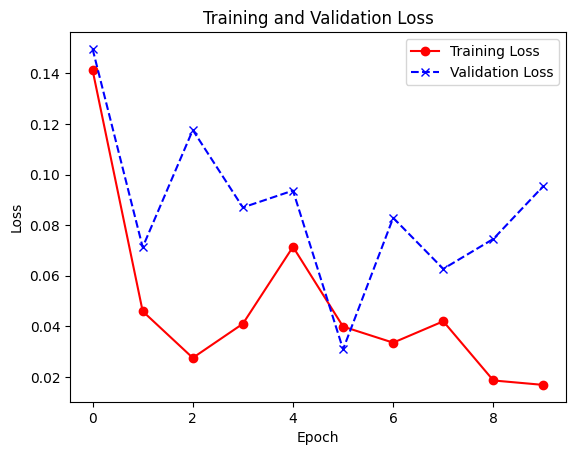

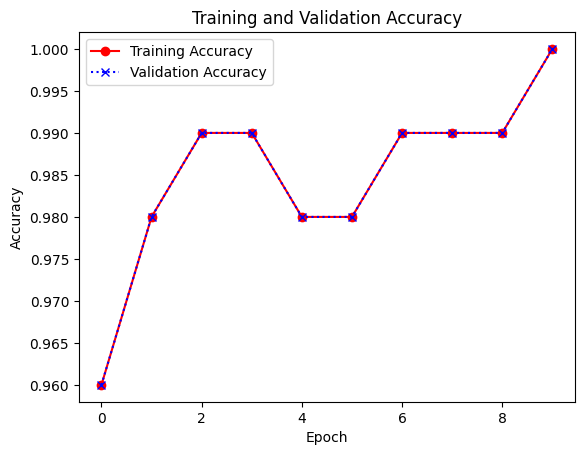

In [17]:
import matplotlib.pyplot as plt

# Plot the training and validation loss over time
plt.plot(range(num_epochs),
		losses, color='red',
		label='Training Loss',
		marker='o')
plt.plot(range(num_epochs),
		val_losses,
		color='blue',
		linestyle='--',
		label='Validation Loss',
		marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy over time
plt.plot(range(num_epochs),
		accuracies,
		label='Training Accuracy',
		color='red',
		marker='o')
plt.plot(range(num_epochs),
		val_accuracies,
		label='Validation Accuracy',
		color='blue',
		linestyle=':',
		marker='x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


<h4>Post-training, assess the model's performance on the test dataset by making predictions and contrasting them with actual labels. A valuable evaluation technique is employing a classification report. This report offers a comprehensive overview of the model's performance across all classes.

To generate this report, leverage the `classification_report` function from the scikit-learn library. This report provides essential metrics, including precision, recall, f1-score, and support, affording insight into the model's effectiveness across various aspects.<h4>

In [18]:
# Create a DataLoader for the test dataset
test_loader = torch.utils.data.DataLoader(test_dataset,
										batch_size=batch_size,
										shuffle=False)

# Evaluate the model on the test dataset
model.eval()

with torch.no_grad():
	correct = 0
	total = 0
	y_true = []
	y_pred = []
	for images, labels in test_loader:
		images = images.to(device)
		labels = labels.to(device)
		outputs = model(images)
		_, predicted = torch.max(outputs.data, 1)
		total += labels.size(0)
		correct += (predicted == labels).sum().item()
		predicted=predicted.to('cpu')
		labels=labels.to('cpu')
		y_true.extend(labels)
		y_pred.extend(predicted)

print('Test Accuracy: {}%'.format(100 * correct / total))

# Generate a classification report

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))


Test Accuracy: 99.08%
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

